In [11]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import pandas as pd
from util import *
plt.style.use('../img/style.mplstyle')


def period_match(df, scores):
    period = jnp.array(df['period'])
    period_injected = jnp.array(df['period_injected'])
    not_found = jnp.abs(period - period_injected)/period_injected > 0.1
    scores = -1e10 * not_found + (1-not_found) * scores
    return scores

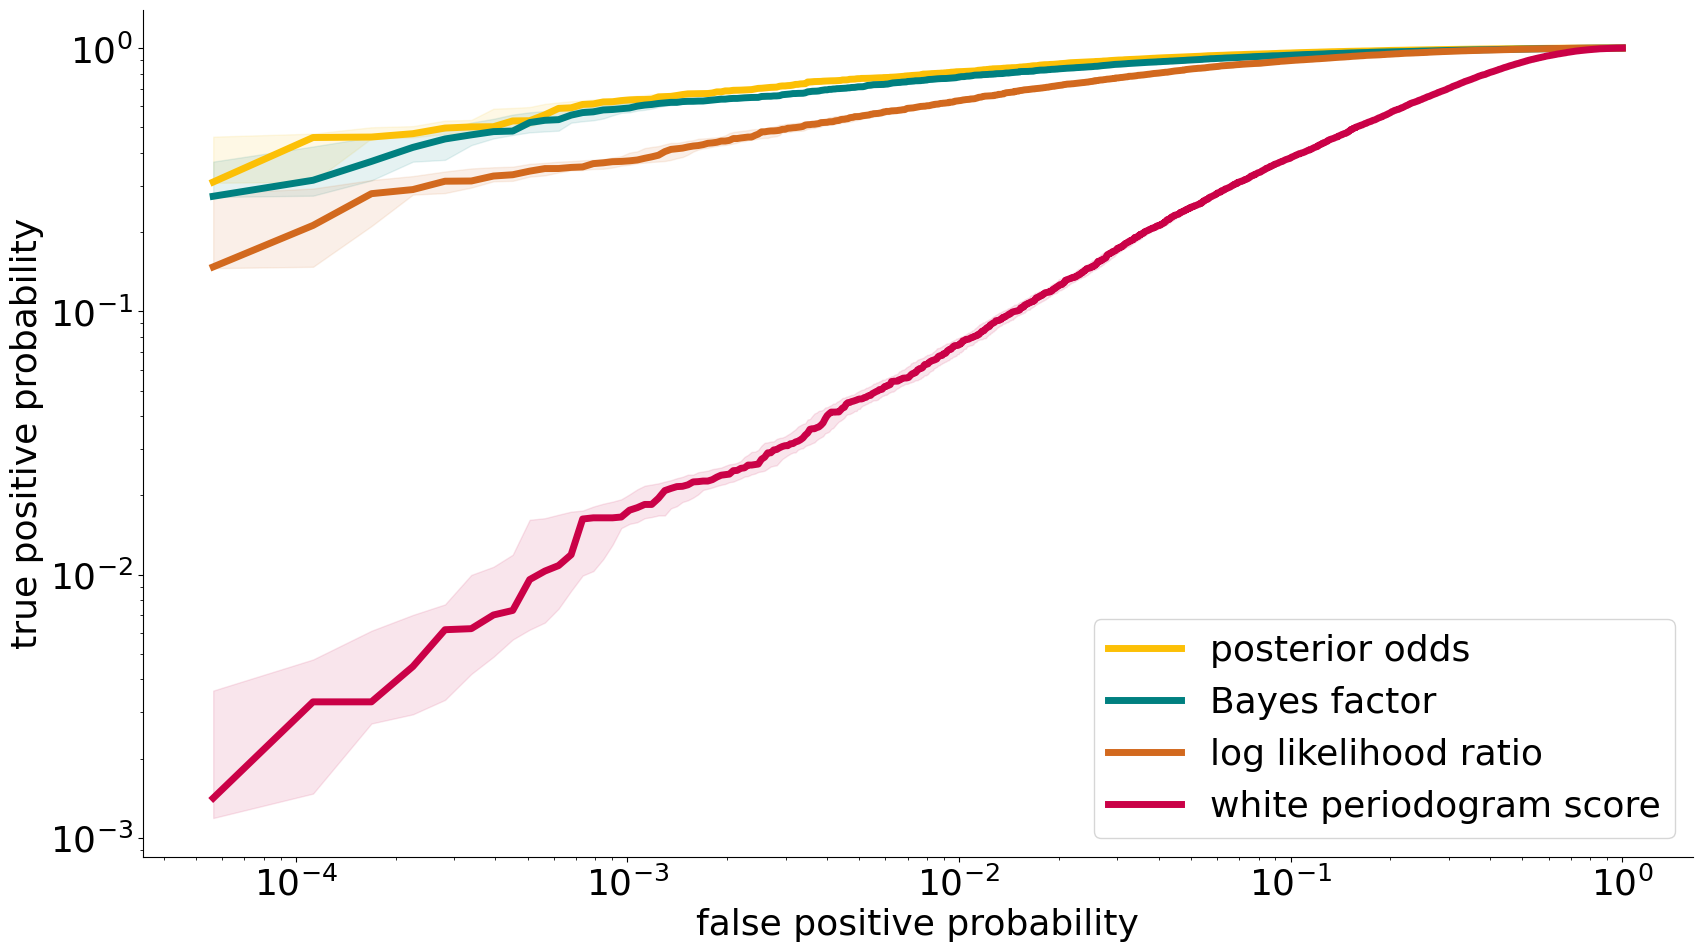

In [13]:
plt.figure(figsize = (20, 11))

ff = 26
plt.yticks(fontsize=ff)
plt.xticks(fontsize=ff)

test_stats = ['log_post_odds', 'logB', 'log_lik_ratio', 'white_periodogram']
labels = ['posterior odds', 'Bayes factor', 'log likelihood ratio', 'white periodogram score']
colors = ['xkcd:marigold', 'teal', 'chocolate', 'xkcd:ruby']

which_amp = 2

for i in range(len(test_stats)):
    
    df= pd.read_csv('../data/sim_0_' + str(which_amp) + '.csv')
    df['log_post_odds'] = df['logB'] + df['log_prior_odds']
    df = df[np.isfinite(df['logB'])]
    scores = np.array(df[test_stats[i]])
    injected = np.isfinite(df['period_injected'])
    
    fpr, tpr, tpr_low, tpr_high = ROC(score_fp= scores[~injected], 
                                      score_true= scores[injected])
    plt.plot(fpr, tpr, label = labels[i], color= colors[i], lw = 5)
    plt.fill_between(fpr, tpr_low, tpr_high, alpha=  0.1, color= colors[i])

plt.xlabel('false positive probability', fontsize = ff)
plt.ylabel('true positive probability', fontsize = ff)
pmin = 1./np.sum(injected)
#plt.xlim(pmin, 1)
#plt.ylim(pmin, 1)
plt.yscale('log')
plt.xscale('log')

plt.legend(fontsize = ff)
plt.savefig('../img/ROC.png')
plt.show()

In [ ]:

def _tpr_at_fixed_fpr(score_fp, score_tp, pval):
    cutoff = -jnp.sort(-score_fp)[int(len(score_fp) * pval)]
    num_realizations= len(score_fp)
    return (num_realizations - jnp.searchsorted(jnp.sort(jnp.array(score_tp)), cutoff)) / num_realizations
    
    
def tpr_at_fixed_fpr(test_stat, pval, test_found= False):
    amps = np.array([0.1, 0.2, 0.3, 0.4]) / 0.1
    score_fpr = read(0, test_stat, test_found)
    tpr = [_tpr_at_fixed_fpr(score_fpr, read(which_amp, test_stat, test_found), pval) for which_amp in range(1, len(amps)+1)]
    return amps, tpr

[Array(0.10296196, dtype=float32), Array(0.5352722, dtype=float32), Array(0.9143067, dtype=float32), Array(0.98287266, dtype=float32)]
[Array(0.09024363, dtype=float32), Array(0.36507264, dtype=float32), Array(0.80037874, dtype=float32), Array(0.942824, dtype=float32)]
[Array(0.05912444, dtype=float32), Array(0.01220925, dtype=float32), Array(0.19455671, dtype=float32), Array(0.05932228, dtype=float32)]


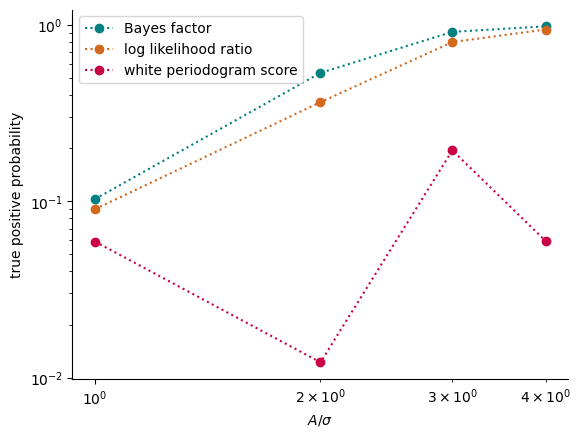

In [9]:
pval = 1e-3
remove_not_found = False

for i in range(len(test_stats)):
    a, TPR = tpr_at_fixed_fpr(test_stats[i], pval, remove_not_found)
    print(TPR)
    plt.plot(a, TPR, 'o:', label = labels[i], color = colors[i])

plt.xlabel(r'$A / \sigma$')
plt.ylabel('true positive probability')
plt.yscale('log')
plt.xscale('log')
plt.legend()

plt.show()

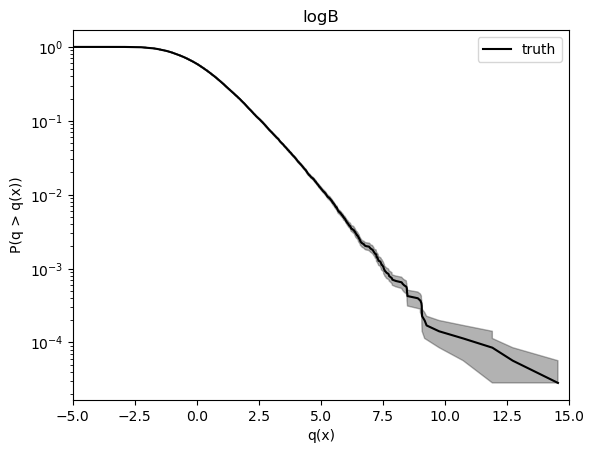

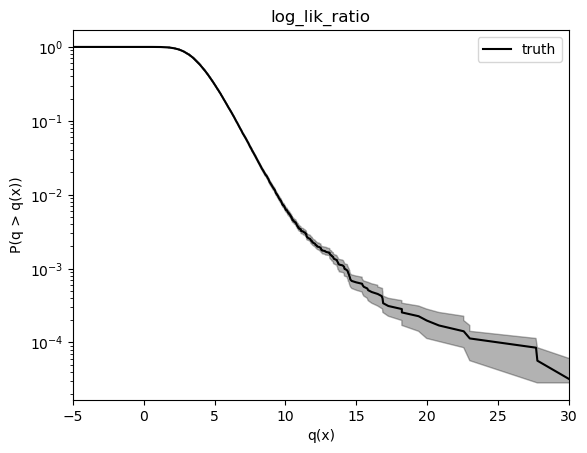

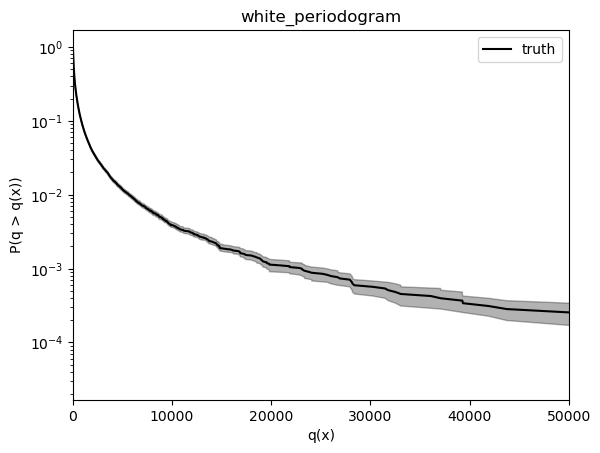

In [14]:
def cdf_plot(name, test_stat, label, color):
    score = read(name, test_stat, False)
    p, x, xmin, xmax = cdf_with_err(score)
    plt.plot(x, p, color = color, label = label)
    plt.fill_betweenx(p, xmin, xmax, color = color, alpha= 0.3)
    
for test_stat in ['logB', 'log_lik_ratio', 'white_periodogram']:
    plt.title(test_stat)
    cdf_plot('amp0.0', test_stat, 'truth', 'black')
    #cdf_plot('amp0.0_randomized', test_stat, 'randomized period', 'teal')
    
    plt.yscale('log')
    plt.xlabel('q(x)')
    plt.ylabel('P(q > q(x))')
    plt.legend()
    plt.xlim(-5, {'logB': 15, 'log_lik_ratio': 30, 'white_periodogram': 50000}[test_stat])
    plt.show()

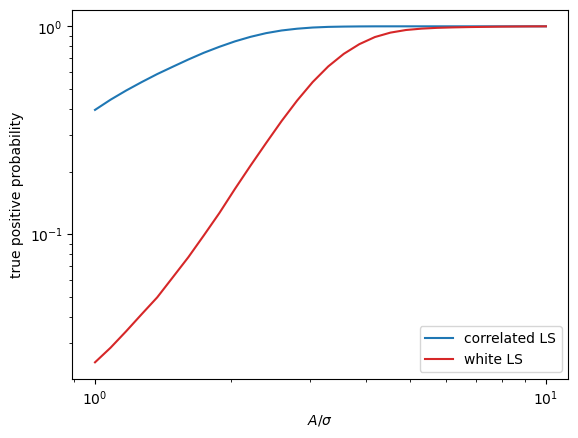

In [3]:

    
pval = 1e-2
plt.plot(*tpr_at_fixed_fpr(pval, 'corrLS'), label = 'correlated LS', color = 'tab:blue')
plt.plot(*tpr_at_fixed_fpr(pval, 'whiteLS'), label = 'white LS', color= 'tab:red')

plt.xlabel(r'$A / \sigma$')
plt.ylabel('true positive probability')
plt.yscale('log')
plt.xscale('log')
plt.legend()
#plt.savefig(save_dir)
plt.show()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


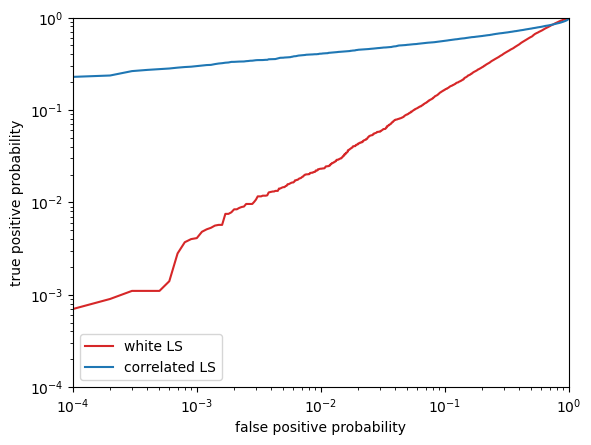

In [2]:
score_fp = jnp.load('results/fp_whiteLS.npy')
score_tp = jnp.load('results/tp_whiteLS.npy')
plt.plot(*ROC(score_fp, score_tp), color = 'tab:red', label = 'white LS')

score_fp = jnp.load('results/fp_corrLS.npy')
score_tp = jnp.load('results/tp_corrLS.npy')
plt.plot(*ROC(score_fp, score_tp), color = 'tab:blue', label = 'correlated LS')


plt.xlabel('false positive probability')
plt.ylabel('true positive probability')
pmin = 1./len(score_fp)
plt.xlim(pmin, 1)
plt.ylim(pmin, 1)
plt.yscale('log')
plt.xscale('log')

plt.legend()
#plt.savefig(save_dir)
plt.show()
